In [65]:
import pandas as pd
import database_load
import numpy as np
import matplotlib.pyplot as plt

In [57]:
def dataframe_creation(cursor, query):
    #load query results into pd df
    cursor.execute(query)
    colnames = [col[0] for col in cursor.description]
    df = pd.DataFrame(cursor.fetchall(), columns=colnames)
    return df


db_connection = database_load.connect_database()
db_cursor = db_connection.cursor()

df = dataframe_creation(db_cursor, 'select * from games')

#close database connection
db_cursor.close()
db_connection.close()

In [58]:
def split_creation(df_in, col_in, step):
    max_rating= df_in[col_in].max()
    min_ratings= df_in[col_in].min()-df_in[col_in].min()%step
    split = []
    while min_ratings <= max_rating:
        split.append(min_ratings)
        min_ratings+= step
    return split
    
#take rating_avg, split into different df
def tier_creation(df_in, col_in, col_out, step):
    tiers = split_creation(df_in, col_in, step)
    tiers.append(float('inf'))
    df_in[col_out] = pd.cut(df_in[col_in], bins=tiers, labels=tiers[:-1], right=False)

In [59]:
def victor(win_in):
    if win_in == 'white':
        return 1
    elif win_in == 'black':
        return -1
    else:
        return 0

In [60]:
results_df = pd.DataFrame(columns=['rating_diff', 'resigned', 'winner', 'expected_win'])
results_df['rating_diff'] = df['white_rating']-df['black_rating']
results_df['resigned'] = np.select([df['victory_status']=='resign'], [True], default=False)
#keep expected win because we need to check who resigned
results_df['winner'] = np.select([df['winner']=='white', df['winner']=='black'], [1,-1],default=0)
results_df['expected_win'] = np.sign(results_df['winner']/results_df['rating_diff'])
print(results_df)

       rating_diff  resigned  winner  expected_win
0              309     False       1           1.0
1               61      True      -1          -1.0
2               -4     False       1          -1.0
3              -15     False       1          -1.0
4               54     False       1           1.0
...            ...       ...     ...           ...
19108          471      True       1           1.0
19109           37     False      -1          -1.0
19110          -67     False       1          -1.0
19111          133      True       1           1.0
19112         -104     False      -1           1.0

[19113 rows x 4 columns]


In [61]:
#create the different datapoints
tier_creation(results_df, 'rating_diff', 'diff_rank',100)

ranked_df = results_df.groupby(['diff_rank', 'resigned'], observed=False).agg(win_amount=('expected_win', 'sum'), game_amount=('winner','count')).reset_index()

In [62]:
#to get correlation
#amount of expected resigns/amount of games(resigned or not)
#first, abs the diff_rank, then add false and true games together
#expected wins/added games for percentage

ranked_df['abs_diff_rank'] = ranked_df['diff_rank'].apply(lambda x: abs(x+100) if x<0 else x)
abs_ranked_df = ranked_df.groupby(['abs_diff_rank', 'resigned'], observed=False).agg(win_amount=('win_amount', 'sum'), game_amount=('game_amount','sum')).reset_index()

In [63]:
expected_outcomes = abs_ranked_df[abs_ranked_df['resigned']==True][['abs_diff_rank', 'win_amount']]
total_games = abs_ranked_df.groupby('abs_diff_rank')['game_amount'].sum().reset_index()
graph_df = pd.merge(expected_outcomes, total_games, on='abs_diff_rank', how='left')
graph_df['resign_percentage']=graph_df['win_amount']/graph_df['game_amount']

#exclude rank differences that have too small sample size
good_graph_df = graph_df[graph_df['game_amount']>10]
print(good_graph_df)

    abs_diff_rank  win_amount  game_amount  resign_percentage
0               0       442.0         8707           0.050764
1             100       767.0         4407           0.174041
2             200       738.0         2541           0.290437
3             300       442.0         1444           0.306094
4             400       326.0          847           0.384888
5             500       210.0          519           0.404624
6             600       107.0          276           0.387681
7             700        66.0          168           0.392857
8             800        31.0           89           0.348315
9             900        24.0           58           0.413793
10           1000         5.0           24           0.208333
11           1100         8.0           13           0.615385
12           1200         7.0           11           0.636364


Text(0, 0.5, 'Resign Percentage')

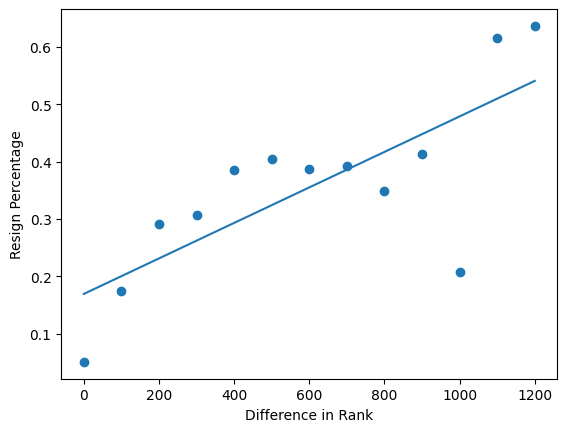

In [64]:
a, b = np.polyfit(good_graph_df['abs_diff_rank'], good_graph_df['resign_percentage'], 1)

plt.figure()
plt.scatter(good_graph_df['abs_diff_rank'], good_graph_df['resign_percentage'])
plt.plot(good_graph_df['abs_diff_rank'], a*good_graph_df['abs_diff_rank']+b)
plt.xlabel("Difference in Rank")
plt.ylabel("Resign Percentage")

The scatter graph shows that while resigns increase as difference in rank increases, it is at a diminishing rate. This is against my expectation as I expected a difference in rank to actually exponentially affect the resign percentage, because I expected players to give up easier when faced with huge odds against them.